In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 14 12:29:42 2015
@author: Reed
"""

import numpy as np
from scipy.spatial import ConvexHull
from collections import OrderedDict
from itertools import product, permutations
import warnings
import matplotlib.pyplot as plt
import pdb
import os
import time

#parameters
filepath = "C:\\Users\\Reed\\Desktop\\vaze_tsp\\tsp_points.npy"
def points_setup(N=100, file=filepath):   
   
    #create one hundred random points
    FullPoints = np.random.rand(N,2)*100 # 100 points generated 
    #save them
    np.save(file, FullPoints)
    return N
    
#create parellel files for python and java with given number of points and files
def parellel_create(N=100,num_files=100):   
    for i in range(1,num_files+1):        
        #create one hundred random points
        FullPoints = np.random.rand(N,2)*100 # 100 points generated 
        #save points in python folder        
        np.save( "C:\\Users\\Reed\\Desktop\\vaze_tsp\\" + "zhullfile_py_%s_%s.npy" % (N, i), FullPoints)
        #save points in java folder
        with open("C:\\Users\\Reed\\eclipse\\workspace\\TSP_ByRef\\" + "zhullfile_jv_%s_%s.txt" % (N, i) , 'w') as outfile:
            outfile.write(str(N) + '\n')
            for point in FullPoints.tolist():
                outfile.write(str(point[0]) + '\t'+str(point[1]) + '\n')
    return "done"
                
        
filepath="C:\\Users\\Reed\\Desktop\\vaze_tsp\\hull.npy"    



'''
for benchmark, binary heap for each interior when comparing for best segment (add /remove), each node is segment point
'''
#perform benckmark Convex Hull alogorithm to solve TSP    
def benchmark(file=filepath):
    #get set of points and number f points
    FullPoints = file
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    ##print(path_indices)
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    ##print(interior_indices_original)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #get starting number of interiors
    num_interiors_original = interior_indices_original.size
    #intialize material for graphing
    graph_material= []
    #a loop adding an interior point to the tour each time
    for i in range(0,num_interiors_original):
        #initialize dictionary of best segments for each point
        best_segment_dict = {}
        interiors = interior_indices.tolist()
        #loop through interiors
        for interior in interiors:
            #find best segment for that interior
            best_segment = []            
            best_distance = -1
            #get coordinates of interior
            interior_point = FullPoints[interior]
            for segment in segments.tolist():
                #get coordinates of segment
                segment_points = FullPoints[segment]
                #calculate distance metric
                distance = np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point) - np.linalg.norm(segment_points[0] - segment_points[1])
                #if it is the best distance so far, save interior/segment combination
                if best_distance == -1 or distance < best_distance:
                    best_segment = segment                    
                    best_distance = distance
            #add interior/segment with best distance metric to dictionary
            best_segment_dict[interior] =  best_segment
        #loop through interior points  again, now with best interiors found, and choose interior poinr to add to tour
        best_interior = -1
        corresponding_best_segment = []
        minRatio = -1 # initialize metric for finding best interior
        for interior, segment in best_segment_dict.items():
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #get coordinates of segment
            segment_points = FullPoints[segment]
            Ratio =  (np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point)) / np.linalg.norm(segment_points[0] - segment_points[1])
            if minRatio == -1 or Ratio < minRatio:
                minRatio = Ratio
                best_interior = interior
                corresponding_best_segment = segment
        #add best interior point found in loop above to subroute between its corresponding best segment
                '''
        print("path indices")
        print(path_indices)
        print("segment second point")
        print(corresponding_best_segment[1])
        print("interior")
        print(best_interior)
        '''
        path_indices = np.insert(path_indices, np.where(path_indices ==corresponding_best_segment[1])[0], best_interior)        
        #recalculate interiors and segments...
        #remove point added to tour from indicies
        interior_indices = np.delete(interior_indices, np.where(interior_indices==best_interior))     
        #get segments from current tour
        segments=construct_segments(path_indices)
        #add to material for graphing
        graph_material.append([path_indices, interior_indices])
        #if there are still more points to add, continue with this loop
    #return final tour length,  OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    return tour_length, num_interiors_original, path_indices, FullPoints, graph_material



def benchmark_steal2(file=filepath):
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    ##print(path_indices)
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    ##print(interior_indices_original)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #get starting number of interiors
    num_interiors_original = interior_indices_original.size
    #intialize material for graphing
    graph_material= []
    #a loop adding an interior point to the tour each time
    for i in range(0,num_interiors_original):
        #initialize dictionary of best segments for each point
        best_segment_dict = {}
        interiors = interior_indices.tolist()
        #loop through interiors
        for interior in interiors:
            #find best segment for that interior
            best_segment = []            
            best_distance = -1
            #get coordinates of interior
            interior_point = FullPoints[interior]
            for segment in segments.tolist():
                #get coordinates of segment
                segment_points = FullPoints[segment]
                #calculate distance metric
                distance = np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point) - np.linalg.norm(segment_points[0] - segment_points[1])
                #if it is the best distance so far, save interior/segment combination
                if best_distance == -1 or distance < best_distance:
                    best_segment = segment                    
                    best_distance = distance
            #add interior/segment with best distance metric to dictionary
            best_segment_dict[interior] =  best_segment
        #loop through interior points  again, now with best interiors found, and choose interior poinr to add to tour
        best_interior = -1
        corresponding_best_segment = []
        minRatio = -1 # initialize metric for finding best interior
        for interior, segment in best_segment_dict.items():
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #get coordinates of segment
            segment_points = FullPoints[segment]
            Ratio =  (np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point)) / np.linalg.norm(segment_points[0] - segment_points[1])
            if minRatio == -1 or Ratio < minRatio:
                minRatio = Ratio
                best_interior = interior
                corresponding_best_segment = segment
        #add best interior point found in loop above to subroute between its corresponding best segment
                '''
        print("path indices")
        print(path_indices)
        print("segment second point")
        print(corresponding_best_segment[1])
        print("interior")
        print(best_interior)
        '''
        path_indices = np.insert(path_indices, np.where(path_indices ==corresponding_best_segment[1])[0], best_interior)        
        
        
        
         ##ADDED: new subpath added, adjust nearby points for minimum length
        end_left = corresponding_best_segment[0]
        end_right = corresponding_best_segment[1]
        if end_left: 
            #ADDED: potentially adjust order of segments near ends of new path  
            try:
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            except IndexError:
                print(path_indices)
                print(segments)
                print(end_left)
                print(end_right)
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            #get full path size
            path_length =path_indices.size
            #5 points to readjust on the left
            left_select = [i if i<path_length else i%path_length for i in range(left_new_index-3, left_new_index+2) ]
            re_adjust_left = path_indices[left_select]
            min_path_left =[[],-1]
            for subroute in permutations(re_adjust_left[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_left[0], subroute[0],subroute[1], subroute[2],re_adjust_left[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_left[1] == -1 or subroute_length < min_path_left[1]:
                    min_path_left=[subroute_full,subroute_length]
            #replace with optimized path if different from original
            if not np.all(re_adjust_left ==min_path_left[0]):
                replacement_index = np.where(path_indices == re_adjust_left[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_left[0])
                '''
                print(path_indices)
                print(repl)
                print(left_new_index)
                print(right_new_index)
                print(min_path_left)
                '''
            #recalculate interior indices
            #5 points to readjust on the right
            right_select = [i if i<path_length else i%path_length for i in range(right_new_index-1, right_new_index+4) ]
            re_adjust_right = path_indices[right_select]
            min_path_right =[[],-1]
            for subroute in permutations(re_adjust_right[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_right[0], subroute[0],subroute[1], subroute[2],re_adjust_right[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_right[1] == -1 or subroute_length < min_path_right[1]:
                    min_path_right=[subroute_full,subroute_length]                
            if not np.all(re_adjust_right ==min_path_right[0]):
                replacement_index = np.where(path_indices == re_adjust_right[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_right[0])
        
        
        
        
        
        #recalculate interiors and segments...
        #remove point added to tour from indicies
        interior_indices = np.delete(interior_indices, np.where(interior_indices==best_interior))     
        #get segments from current tour
        segments=construct_segments(path_indices)
        #add to material for graphing
        graph_material.append([path_indices, interior_indices])
        #if there are still more points to add, continue with this loop
    #return final tour length,  OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    return tour_length, num_interiors_original, path_indices, FullPoints, graph_material
    






#perform benckmark Convex Hull alogorithm to solve TSP    
def benchmark_improved(file=filepath):
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    ##print(path_indices)
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    ##print(interior_indices_original)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #get starting number of interiors
    num_interiors_original = interior_indices_original.size
    #intialize material for graphing
    graph_material= []
    #a loop adding an interior point to the tour each time
    for i in range(0,num_interiors_original):
        #initialize dictionary of best segments for each point
        best_segment_dict = {}
        interiors = interior_indices.tolist()
        minRatio = -1 # initialize metric for finding best interior
        #loop through interiors
        for interior in interiors:
            #find best segment for that interior
            best_segment = []            
            best_distance = -1
            #get coordinates of interior
            interior_point = FullPoints[interior]
            for segment in segments.tolist():
                #get coordinates of segment
                segment_points = FullPoints[segment]
                #calculate distance metric
                distance = np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point) - np.linalg.norm(segment_points[0] - segment_points[1])
                #if it is the best distance so far, save interior/segment combination
                if best_distance == -1 or distance < best_distance:
                    best_segment = segment                    
                    best_distance = distance
            #add interior/segment with best distance metric to dictionary
            best_segment_dict[interior] =  [best_segment]
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #get coordinates of segment
            segment_points = FullPoints[segment]
            Ratio =  (np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point)) / np.linalg.norm(segment_points[0] - segment_points[1])
            if minRatio == -1 or Ratio < minRatio:
                minRatio = Ratio
                best_interior = interior
                corresponding_best_segment = segment
      
        #add best interior point found in loop above to subroute between its corresponding best segment        
        path_indices = np.insert(path_indices, np.where(path_indices ==corresponding_best_segment[1])[0], best_interior)        
        #recalculate interiors and segments...
        #remove point added to tour from indicies
        interior_indices = np.delete(interior_indices, np.where(interior_indices==best_interior))     
        #get segments from current tour
        segments=construct_segments(path_indices)
        #add to material for graphing
        #graph_material.append([path_indices, interior_indices])
        #if there are still more points to add, continue with this loop
    #return final tour length,  OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    return tour_length, num_interiors_original, path_indices, FullPoints, graph_material
    



#perform benckmark Convex Hull alogorithm to solve TSP, with additional check to make sure interior points added to the path are visible    
def benchmark_visible_improved(file=filepath):
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    ##print(path_indices)
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    ##print(interior_indices_original)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #get starting number of interiors
    num_interiors_original = interior_indices_original.size
    #intialize material for graphing
    graph_material= []
    #a loop adding an interior point to the tour each time
    for i in range(0,num_interiors_original):
        #initialize dictionary of best segments for each point
        best_segment_dict = {}
        interiors = interior_indices.tolist()
        minRatio = -1 # initialize metric for finding best interior
        #loop through interiors
        for interior in interiors:
            #find best segment for that interior
            best_segment = []            
            best_distance = -1
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #for each segment in tour
            for segment in segments.tolist():
                #get coordinates of segment
                segment_points = FullPoints[segment]
                #get barycentric coordinates of current path
                path_points = FullPoints[path_indices]
                #if point is visible from the segment ( in other words, no tour points between segment and interior point...)
                if is_visible(interior_point, segment_points, path_points ):
                    #calculate distance metric
                    distance = np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point) - np.linalg.norm(segment_points[0] - segment_points[1])
                    #if it is the best distance so far, save interior/segment combination
                    if best_distance == -1 or distance < best_distance:
                        best_segment = segment                    
                        best_distance = distance
            #add interior/segment with best distance metric to dictionary
            best_segment_dict[interior] =  [best_segment]
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #get coordinates of segment
            segment_points = FullPoints[segment]
            Ratio =  (np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point)) / np.linalg.norm(segment_points[0] - segment_points[1])
            if minRatio == -1 or Ratio < minRatio:
                minRatio = Ratio
                best_interior = interior
                corresponding_best_segment = segment
      
        #add best interior point found in loop above to subroute between its corresponding best segment        
        path_indices = np.insert(path_indices, np.where(path_indices ==corresponding_best_segment[1])[0], best_interior)        
        #recalculate interiors and segments...
        #remove point added to tour from indicies
        interior_indices = np.delete(interior_indices, np.where(interior_indices==best_interior))     
        #get segments from current tour
        segments=construct_segments(path_indices)
        #add to material for graphing
        #graph_material.append([path_indices, interior_indices])
        #if there are still more points to add, continue with this loop
    #return final tour length,  OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    return tour_length, num_interiors_original, path_indices, FullPoints, graph_material
    
def benchmark_visible(file=filepath):
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    ##print(path_indices)
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    ##print(interior_indices_original)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #get starting number of interiors
    num_interiors_original = interior_indices_original.size
    #intialize material for graphing
    graph_material= []
    #a loop adding an interior point to the tour each time
    for i in range(0,num_interiors_original):
        #initialize dictionary of best segments for each point
        best_segment_dict = {}
        interiors = interior_indices.tolist()
        #loop through interiors
        for interior in interiors:
            #find best segment for that interior
            best_segment = []            
            best_distance = -1
            #get coordinates of interior
            interior_point = FullPoints[interior]
            for segment in segments.tolist():
                #get coordinates of segment
                segment_points = FullPoints[segment]
                #get  coordinates of current path
                path_points = FullPoints[path_indices]
                #if point is visible from the segment ( in other words, no tour points between segment and interior point...)
                if is_visible(interior_point, segment_points, path_points ):
                   
                    #calculate distance metric
                    distance = np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point) - np.linalg.norm(segment_points[0] - segment_points[1])
                    #if it is the best distance so far, save interior/segment combination
                    
                    if best_distance == -1 or distance < best_distance:
                        best_segment = segment                    
                        best_distance = distance
            #add interior/segment with best distance metric to dictionary
            best_segment_dict[interior] =  best_segment
        #loop through interior points  again, now with best interiors found, and choose interior poinr to add to tour
        best_interior = -1
        corresponding_best_segment = []
        minRatio = -1 # initialize metric for finding best interior
        for interior, segment in best_segment_dict.items():
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #get coordinates of segment
            segment_points = FullPoints[segment]
            Ratio =  (np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point)) / np.linalg.norm(segment_points[0] - segment_points[1])
            if minRatio == -1 or Ratio < minRatio:
                minRatio = Ratio
                best_interior = interior
                corresponding_best_segment = segment
        #add best interior point found in loop above to subroute between its corresponding best segment
                '''
        print("path indices")
        print(path_indices)
        print("segment second point")
        print(corresponding_best_segment[1])
        print("interior")
        print(best_interior)
        '''
        path_indices = np.insert(path_indices, np.where(path_indices ==corresponding_best_segment[1])[0], best_interior)        
        #recalculate interiors and segments...
        #remove point added to tour from indicies
        interior_indices = np.delete(interior_indices, np.where(interior_indices==best_interior))     
        #get segments from current tour
        segments=construct_segments(path_indices)
        #add to material for graphing
        graph_material.append([path_indices, interior_indices])
        #if there are still more points to add, continue with this loop
    #return final tour length,  OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    return tour_length, num_interiors_original, path_indices, FullPoints, graph_material
    


def benchmark_visible_steal2(file=filepath):
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    ##print(path_indices)
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    ##print(interior_indices_original)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #get starting number of interiors
    num_interiors_original = interior_indices_original.size
    #intialize material for graphing
    graph_material= []
    #a loop adding an interior point to the tour each time
    for i in range(0,num_interiors_original):
        #initialize dictionary of best segments for each point
        best_segment_dict = {}
        interiors = interior_indices.tolist()
        #loop through interiors
        for interior in interiors:
            #find best segment for that interior
            best_segment = []            
            best_distance = -1
            #get coordinates of interior
            interior_point = FullPoints[interior]
            for segment in segments.tolist():
                #get coordinates of segment
                segment_points = FullPoints[segment]
                #get  coordinates of current path
                path_points = FullPoints[path_indices]
                #if point is visible from the segment ( in other words, no tour points between segment and interior point...)
                if is_visible(interior_point, segment_points, path_points ):
                   
                    #calculate distance metric
                    distance = np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point) - np.linalg.norm(segment_points[0] - segment_points[1])
                    #if it is the best distance so far, save interior/segment combination
                    
                    if best_distance == -1 or distance < best_distance:
                        best_segment = segment                    
                        best_distance = distance
            #add interior/segment with best distance metric to dictionary
            best_segment_dict[interior] =  best_segment
        #loop through interior points  again, now with best interiors found, and choose interior poinr to add to tour
        best_interior = -1
        corresponding_best_segment = []
        minRatio = -1 # initialize metric for finding best interior
        for interior, segment in best_segment_dict.items():
            #get coordinates of interior
            interior_point = FullPoints[interior]
            #get coordinates of segment
            segment_points = FullPoints[segment]
            Ratio =  (np.linalg.norm(segment_points[0] - interior_point)  + np.linalg.norm(segment_points[1] - interior_point)) / np.linalg.norm(segment_points[0] - segment_points[1])
            if minRatio == -1 or Ratio < minRatio:
                minRatio = Ratio
                best_interior = interior
                corresponding_best_segment = segment
        #add best interior point found in loop above to subroute between its corresponding best segment
                '''
        print("path indices")
        print(path_indices)
        print("segment second point")
        print(corresponding_best_segment[1])
        print("interior")
        print(best_interior)
        '''
        path_indices = np.insert(path_indices, np.where(path_indices ==corresponding_best_segment[1])[0], best_interior)        
        ##ADDED: new subpath added, adjust nearby points for minimum length
        end_left = corresponding_best_segment[0]
        end_right = corresponding_best_segment[1]
        if end_left: 
            #ADDED: potentially adjust order of segments near ends of new path  
            try:
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            except IndexError:
                print(path_indices)
                print(segments)
                print(end_left)
                print(end_right)
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            #get full path size
            path_length =path_indices.size
            #5 points to readjust on the left
            left_select = [i if i<path_length else i%path_length for i in range(left_new_index-3, left_new_index+2) ]
            re_adjust_left = path_indices[left_select]
            min_path_left =[[],-1]
            for subroute in permutations(re_adjust_left[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_left[0], subroute[0],subroute[1], subroute[2],re_adjust_left[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_left[1] == -1 or subroute_length < min_path_left[1]:
                    min_path_left=[subroute_full,subroute_length]
            #replace with optimized path if different from original
            if not np.all(re_adjust_left ==min_path_left[0]):
                replacement_index = np.where(path_indices == re_adjust_left[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_left[0])
                '''
                print(path_indices)
                print(repl)
                print(left_new_index)
                print(right_new_index)
                print(min_path_left)
                '''
            #recalculate interior indices
            #5 points to readjust on the right
            right_select = [i if i<path_length else i%path_length for i in range(right_new_index-1, right_new_index+4) ]
            re_adjust_right = path_indices[right_select]
            min_path_right =[[],-1]
            for subroute in permutations(re_adjust_right[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_right[0], subroute[0],subroute[1], subroute[2],re_adjust_right[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_right[1] == -1 or subroute_length < min_path_right[1]:
                    min_path_right=[subroute_full,subroute_length]                
            if not np.all(re_adjust_right ==min_path_right[0]):
                replacement_index = np.where(path_indices == re_adjust_right[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_right[0])
        
        
        
        #recalculate interiors and segments...
        #remove point added to tour from indicies
        interior_indices = np.delete(interior_indices, np.where(interior_indices==best_interior))     
        #get segments from current tour
        segments=construct_segments(path_indices)
        #add to material for graphing
        graph_material.append([path_indices, interior_indices])
        ##print(len(path_indices))
        #if there are still more points to add, continue with this loop
    #return final tour length,  OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    return tour_length, num_interiors_original, path_indices, FullPoints, graph_material
    
    

def TSP_solver(file, association_function, subpath_function, tiebreaker_function, tour_function):
    np.seterr(all='warn')
    #get set of points and number f points
    FullPoints = file
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #run algorithm, expanding scope until all points are covered
    loop_count = 0 #initialize loop count
    graph_material = []
    while path_indices.size < N:  #takes in variables segments, path_indices, interior_indices, these variables will be modified each loop
        #STEP 2: for each segment of the current path defined by "segments", 
        #associate a set of interior points (reduced set of indicies from interior_indices) according to a distance metric and save  in  dictionary
        #and calculate a subpath between those points using the given subpath function
        interior_dict = OrderedDict()
        subpath_dict = OrderedDict() #initialize dict to store subpaths for each segment
        for segment in segments.tolist():
            #get coordinates of both segment points 
            segment_points=FullPoints[segment]
            #distance between segment points
            segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
            #get interior points (as indices) associated with current segment using given association function
            interiors_for_segment =  association_function(segment_length, segment_points, interior_indices, FullPoints, loop_count, N)
            #save these points in a dictionary keyed by segment indices
            interior_dict[tuple(segment)] = interiors_for_segment
            #get interior coordinates
            interior_points = FullPoints[interiors_for_segment]
            #get subpath through these points using given subpath function            
            segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
            ##if(91 in segment_subpath and loop_count==35):
              ##  pdb.set_trace()
            #save subpath in a dict keyed by segment
            subpath_dict[tuple(segment)] = segment_subpath
        #STEP 3: find overlaps between subpaths, remove these overlaps from all except for path where
        # overlap fits "best" according to given tie-breaking function
              
        overlaps_left = True #assume there are some overlaps to begin loop
        #dictionary keyed by interior point, value contains segment and the distance metric
        best_segments = {}
        donepoints = [] # list of points where overlaps have been removed
        farthestDist = -1
        while overlaps_left:
            overlaps_left = False
            #iterate through subpaths, get "best" segment according to distance metric
            for segment, subpath in subpath_dict.items():
                segment= list(segment)
                #get interiors of subpath
                subpath_interiors = subpath[1:-1]
                #for each interior point
                for int_point in subpath_interiors:
                    if not int_point in donepoints: #if point not already taken care of...
                        #get tie breaking distance
                        dist = tiebreaker_function(segment, int_point, FullPoints)
                        if tiebreaker_function.__name__ == 'TSP2_tiebreaker':                        #interior point, associated segment and distance metric to dictionary of "best" points if qualified
                            if (not int_point in best_segments) or ( dist>best_segments[int_point][1]):                           
                                best_segments[int_point] = [segment, dist]
                                overlaps_left = True #there is still an overlap!
                        elif tiebreaker_function.__name__ == 'TSP_tiebreaker':                                                  
                            if farthestDist == -1 or dist > farthestDist:
                                farthestDist = dist
                                #save interior point associated with this dist
                                farthest_int = int_point
                                #save segment associated with this ratio
                                farthest_segment = segment            
                                overlaps_left = True #there is still an overlap!
            #if no overlaps found in previous loop, break
            if not overlaps_left:
                break
            
            
            #find next overlapping point to be removed (depending on tiebreaker function) and the segment with which it will remain
            
            if tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                minRatio = -1 #initialize minimum ratio between sum of distances of interior to segment points and the segment length
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    # ratio between sum of distances of interior to segment points and the segment length
                    #note: will be larger if the point is further away from the segment
                    Ratio = (np.linalg.norm(segment_points[0]-int_location) + np.linalg.norm(segment_points[1]-int_location))/segment_length
                    #if minRatio has not been found or current ratio is less than min ratio, update minRatio with current Ratio
                    #interior point associated with this minRatio will be removed from all subpaths but the one associated with the segment involved in this ratio
                    if minRatio == -1 or Ratio < minRatio:
                        minRatio = Ratio
                        #save interior point associated with this ratio
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
             
            '''#
            elif tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                farthestDist = -1
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    #get distance stat calculated earlier
                    dist = segment_stats[1]
                    #find point with greatest dist
                    if farthestDist == -1 or dist > farthestDist:
                        farthestDist = dist
                        #save interior point associated with this dist
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
            '''
            #remove farthest interior point from all segments but the "best" according to tiebreaker
            for segment, interior in interior_dict.items():
                segment= list(segment)
                if segment != farthest_segment: #i.e. if the point is not to remain in this segment
                    #remove the point from interior points                    
                    farthest_p_loc = np.where(interior==farthest_int)
                    interiors_for_segment  = np.delete(interior, farthest_p_loc)
                    interior_dict[tuple(segment)] = interiors_for_segment
                    if farthest_p_loc[0]: #i.e. if point was found in interior and removed above, recalulate subpath without point
                        
                        #get coordinates of both segment points 
                        segment_points=FullPoints[segment]
                        #distance between segment points
                        segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
                        #get interior coordinates
                        interior_points = FullPoints[interiors_for_segment]
                        #recalculate subpath for this segment using given subpath function                        
                        segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
                        #save subpath in a dict keyed by segment
                        subpath_dict[tuple(segment)] = segment_subpath
                        
                        
                        
            #add point to list of overlaps removed
            donepoints.append(farthest_int)
            
                
            
        #STEP 4: recalulate current tour
        segments, path_indices, interior_indices = tour_function(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices)
        #increment loop count 
        loop_count +=1
        graph_material.append([path_indices, interior_indices])
        
    
    #return final tour length, loop count, OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    
    return tour_length, loop_count, path_indices, FullPoints, graph_material



def TSP_solver_steal2(file, association_function, subpath_function, tiebreaker_function, tour_function):
    np.seterr(all='warn')
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #run algorithm, expanding scope until all points are covered
    loop_count = 0 #initialize loop count
    graph_material = []
    while path_indices.size < N:  #takes in variables segments, path_indices, interior_indices, these variables will be modified each loop
        #STEP 2: for each segment of the current path defined by "segments", 
        #associate a set of interior points (reduced set of indicies from interior_indices) according to a distance metric and save  in  dictionary
        #and calculate a subpath between those points using the given subpath function
        interior_dict = OrderedDict()
        subpath_dict = OrderedDict() #initialize dict to store subpaths for each segment
        for segment in segments.tolist():
            #get coordinates of both segment points 
            segment_points=FullPoints[segment]
            #distance between segment points
            segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
            #get interior points (as indices) associated with current segment using given association function
            interiors_for_segment =  association_function(segment_length, segment_points, interior_indices, FullPoints, loop_count, N)
            #save these points in a dictionary keyed by segment indices
            interior_dict[tuple(segment)] = interiors_for_segment
            #get interior coordinates
            interior_points = FullPoints[interiors_for_segment]
            #get subpath through these points using given subpath function            
            segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
            ##if(91 in segment_subpath and loop_count==35):
              ##  pdb.set_trace()
            #save subpath in a dict keyed by segment
            subpath_dict[tuple(segment)] = segment_subpath
        #STEP 3: find overlaps between subpaths, remove these overlaps from all except for path where
        # overlap fits "best" according to given tie-breaking function
              
        overlaps_left = True #assume there are some overlaps to begin loop
        #dictionary keyed by interior point, value contains segment and the distance metric
        best_segments = {}
        donepoints = [] # list of points where overlaps have been removed
        farthestDist = -1
        while overlaps_left:
            overlaps_left = False
            #iterate through subpaths, get "best" segment according to distance metric
            for segment, subpath in subpath_dict.items():
                segment= list(segment)
                #get interiors of subpath
                subpath_interiors = subpath[1:-1]
                #for each interior point
                for int_point in subpath_interiors:
                    if not int_point in donepoints: #if point not already taken care of...
                        #get tie breaking distance
                        dist = tiebreaker_function(segment, int_point, FullPoints)
                        if tiebreaker_function.__name__ == 'TSP2_tiebreaker':                        #interior point, associated segment and distance metric to dictionary of "best" points if qualified
                            if (not int_point in best_segments) or ( dist>best_segments[int_point][1]):                           
                                best_segments[int_point] = [segment, dist]
                                overlaps_left = True #there is still an overlap!
                        elif tiebreaker_function.__name__ == 'TSP_tiebreaker':                                                  
                            if farthestDist == -1 or dist > farthestDist:
                                farthestDist = dist
                                #save interior point associated with this dist
                                farthest_int = int_point
                                #save segment associated with this ratio
                                farthest_segment = segment            
                                overlaps_left = True #there is still an overlap!
            #if no overlaps found in previous loop, break
            if not overlaps_left:
                break
            
            
            #find next overlapping point to be removed (depending on tiebreaker function) and the segment with which it will remain
            
            if tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                minRatio = -1 #initialize minimum ratio between sum of distances of interior to segment points and the segment length
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    # ratio between sum of distances of interior to segment points and the segment length
                    #note: will be larger if the point is further away from the segment
                    Ratio = (np.linalg.norm(segment_points[0]-int_location) + np.linalg.norm(segment_points[1]-int_location))/segment_length
                    #if minRatio has not been found or current ratio is less than min ratio, update minRatio with current Ratio
                    #interior point associated with this minRatio will be removed from all subpaths but the one associated with the segment involved in this ratio
                    if minRatio == -1 or Ratio < minRatio:
                        minRatio = Ratio
                        #save interior point associated with this ratio
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
             
            '''#
            elif tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                farthestDist = -1
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    #get distance stat calculated earlier
                    dist = segment_stats[1]
                    #find point with greatest dist
                    if farthestDist == -1 or dist > farthestDist:
                        farthestDist = dist
                        #save interior point associated with this dist
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
            '''
            #remove farthest interior point from all segments but the "best" according to tiebreaker
            for segment, interior in interior_dict.items():
                segment= list(segment)
                if segment != farthest_segment: #i.e. if the point is not to remain in this segment
                    #remove the point from interior points                    
                    farthest_p_loc = np.where(interior==farthest_int)
                    interiors_for_segment  = np.delete(interior, farthest_p_loc)
                    interior_dict[tuple(segment)] = interiors_for_segment
                    if farthest_p_loc[0]: #i.e. if point was found in interior and removed above, recalulate subpath without point
                        
                        #get coordinates of both segment points 
                        segment_points=FullPoints[segment]
                        #distance between segment points
                        segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
                        #get interior coordinates
                        interior_points = FullPoints[interiors_for_segment]
                        #recalculate subpath for this segment using given subpath function                        
                        segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
                        #save subpath in a dict keyed by segment
                        subpath_dict[tuple(segment)] = segment_subpath
                        
                        
                        
            #add point to list of overlaps removed
            donepoints.append(farthest_int)
            
                
            
        #STEP 4: recalulate current tour
        segments, path_indices, interior_indices,  end_left, end_right = incr_tour_steal2(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices)
        ##ADDED: new subpath added, adjust nearby points for minimum length      
        if end_left >= 0: 
            #ADDED: potentially adjust order of segments near ends of new path  
            try:
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            except IndexError:
                print(path_indices)
                print(segments)
                print(end_left)
                print(end_right)
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            #get full path size
            path_length =path_indices.size
            #5 points to readjust on the left
            left_select = [i if i<path_length else i%path_length for i in range(left_new_index-3, left_new_index+2) ]
            re_adjust_left = path_indices[left_select]
            min_path_left =[[],-1]
            for subroute in permutations(re_adjust_left[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_left[0], subroute[0],subroute[1], subroute[2],re_adjust_left[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_left[1] == -1 or subroute_length < min_path_left[1]:
                    min_path_left=[subroute_full,subroute_length]
            #replace with optimized path if different from original
            if not np.all(re_adjust_left ==min_path_left[0]):
                replacement_index = np.where(path_indices == re_adjust_left[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_left[0])
                '''
                print(path_indices)
                print(repl)
                print(left_new_index)
                print(right_new_index)
                print(min_path_left)
                '''
            #recalculate interior indices
            #5 points to readjust on the right
            right_select = [i if i<path_length else i%path_length for i in range(right_new_index-1, right_new_index+4) ]
            re_adjust_right = path_indices[right_select]
            min_path_right =[[],-1]
            for subroute in permutations(re_adjust_right[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_right[0], subroute[0],subroute[1], subroute[2],re_adjust_right[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_right[1] == -1 or subroute_length < min_path_right[1]:
                    min_path_right=[subroute_full,subroute_length]                
            if not np.all(re_adjust_right ==min_path_right[0]):
                replacement_index = np.where(path_indices == re_adjust_right[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_right[0])
        
        #increment loop count 
        loop_count +=1
        graph_material.append([path_indices, interior_indices])
        
    
    #return final tour length, loop count, OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    
    return tour_length, loop_count, path_indices, FullPoints, graph_material






def TSP_solver_visible_steal2(file, association_function, subpath_function, tiebreaker_function, tour_function):
    np.seterr(all='warn')
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #run algorithm, expanding scope until all points are covered
    loop_count = 0 #initialize loop count
    graph_material = []
    
    while path_indices.size < N:  #takes in variables segments, path_indices, interior_indices, these variables will be modified each loop
        #STEP 2: for each segment of the current path defined by "segments", 
        #associate a set of interior points (reduced set of indicies from interior_indices) according to a distance metric and save  in  dictionary
        #and calculate a subpath between those points using the given subpath function
        interior_dict = OrderedDict()
        subpath_dict = OrderedDict() #initialize dict to store subpaths for each segment
        for segment in segments.tolist():
            #get coordinates of both segment points 
            segment_points=FullPoints[segment]
            #distance between segment points
            segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
            #get interior points (as indices) associated with current segment using given association function
            interiors_for_segment =  association_function(segment_length, segment_points, interior_indices, FullPoints, loop_count, N)
           
            '''
            #get  coordinates of current path
            path_points = FullPoints[path_indices]
            #ADDED STEP: eliminate non visibile points
            if interiors_for_segment.size:
                interiors_for_segment = interiors_for_segment[np.apply_along_axis(is_visible,1, FullPoints[interiors_for_segment], segment_points, path_points)]
            '''
            #ADDED STEP: eliminate  points that would cause intersections with tour
            if interiors_for_segment.size:
                interiors_for_segment= interiors_for_segment[np.apply_along_axis(tour_intersect_test, 1,FullPoints[interiors_for_segment],segment, segment_points, segments, FullPoints )]
            
            #save these points in a dictionary keyed by segment indices
            interior_dict[tuple(segment)] = interiors_for_segment
            #get interior coordinates
            interior_points = FullPoints[interiors_for_segment]
            #get subpath through these points using given subpath function            
            segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
            ##if(91 in segment_subpath and loop_count==35):
              ##  pdb.set_trace()
            #save subpath in a dict keyed by segment
            subpath_dict[tuple(segment)] = segment_subpath
        #STEP 3: find overlaps between subpaths, remove these overlaps from all except for path where
        # overlap fits "best" according to given tie-breaking function
              
        overlaps_left = True #assume there are some overlaps to begin loop
        #dictionary keyed by interior point, value contains segment and the distance metric
        best_segments = {}
        donepoints = [] # list of points where overlaps have been removed
        farthestDist = -1
        while overlaps_left:
            overlaps_left = False
            #iterate through subpaths, get "best" segment according to distance metric
            for segment, subpath in subpath_dict.items():
                segment= list(segment)
                #get interiors of subpath
                subpath_interiors = subpath[1:-1]
                #for each interior point
                for int_point in subpath_interiors:
                    if not int_point in donepoints: #if point not already taken care of...
                        #get tie breaking distance
                        dist = tiebreaker_function(segment, int_point, FullPoints)
                        if tiebreaker_function.__name__ == 'TSP2_tiebreaker':                        #interior point, associated segment and distance metric to dictionary of "best" points if qualified
                            if (not int_point in best_segments) or ( dist>best_segments[int_point][1]):                           
                                best_segments[int_point] = [segment, dist]
                                overlaps_left = True #there is still an overlap!
                        elif tiebreaker_function.__name__ == 'TSP_tiebreaker':                                                  
                            if farthestDist == -1 or dist > farthestDist:
                                farthestDist = dist
                                #save interior point associated with this dist
                                farthest_int = int_point
                                #save segment associated with this ratio
                                farthest_segment = segment            
                                overlaps_left = True #there is still an overlap!
            #if no overlaps found in previous loop, break
            if not overlaps_left:
                break
            
            
            #find next overlapping point to be removed (depending on tiebreaker function) and the segment with which it will remain
            
            if tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                minRatio = -1 #initialize minimum ratio between sum of distances of interior to segment points and the segment length
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    # ratio between sum of distances of interior to segment points and the segment length
                    #note: will be larger if the point is further away from the segment
                    Ratio = (np.linalg.norm(segment_points[0]-int_location) + np.linalg.norm(segment_points[1]-int_location))/segment_length
                    #if minRatio has not been found or current ratio is less than min ratio, update minRatio with current Ratio
                    #interior point associated with this minRatio will be removed from all subpaths but the one associated with the segment involved in this ratio
                    if minRatio == -1 or Ratio < minRatio:
                        minRatio = Ratio
                        #save interior point associated with this ratio
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
             
            '''#
            elif tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                farthestDist = -1
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    #get distance stat calculated earlier
                    dist = segment_stats[1]
                    #find point with greatest dist
                    if farthestDist == -1 or dist > farthestDist:
                        farthestDist = dist
                        #save interior point associated with this dist
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
            '''
            #remove farthest interior point from all segments but the "best" according to tiebreaker
            for segment, interior in interior_dict.items():
                segment= list(segment)
                if segment != farthest_segment: #i.e. if the point is not to remain in this segment
                    #remove the point from interior points                    
                    farthest_p_loc = np.where(interior==farthest_int)
                    interiors_for_segment  = np.delete(interior, farthest_p_loc)
                    interior_dict[tuple(segment)] = interiors_for_segment
                    if farthest_p_loc[0]: #i.e. if point was found in interior and removed above, recalulate subpath without point
                        
                        #get coordinates of both segment points 
                        segment_points=FullPoints[segment]
                        #distance between segment points
                        segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
                        #get interior coordinates
                        interior_points = FullPoints[interiors_for_segment]
                        #recalculate subpath for this segment using given subpath function                        
                        segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
                        #save subpath in a dict keyed by segment
                        subpath_dict[tuple(segment)] = segment_subpath
                        
                        
                        
            #add point to list of overlaps removed
            donepoints.append(farthest_int)
            
                
            
        #STEP 4: recalulate current tour
        segments, path_indices, interior_indices, end_left, end_right = incr_tour_steal2(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices)
        ##ADDED: new subpath added, adjust nearby points for minimum length      
        if end_left >= 0: 
            #ADDED: potentially adjust order of segments near ends of new path  
            try:
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            except IndexError:
                print(path_indices)
                print(segments)
                print(end_left)
                print(end_right)
                left_new_index =np.where(path_indices == end_left)[0][0]
                right_new_index = np.where(path_indices == end_right)[0][0]
            #get full path size
            path_length =path_indices.size
            #5 points to readjust on the left
            left_select = [i if i<path_length else i%path_length for i in range(left_new_index-3, left_new_index+2) ]
            re_adjust_left = path_indices[left_select]
            min_path_left =[[],-1]
            for subroute in permutations(re_adjust_left[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_left[0], subroute[0],subroute[1], subroute[2],re_adjust_left[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_left[1] == -1 or subroute_length < min_path_left[1]:
                    min_path_left=[subroute_full,subroute_length]
            #replace with optimized path if different from original
            if not np.all(re_adjust_left ==min_path_left[0]):
                replacement_index = np.where(path_indices == re_adjust_left[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_left[0])
                '''
                print(path_indices)
                print(repl)
                print(left_new_index)
                print(right_new_index)
                print(min_path_left)
                '''
            #recalculate interior indices
            #5 points to readjust on the right
            right_select = [i if i<path_length else i%path_length for i in range(right_new_index-1, right_new_index+4) ]
            re_adjust_right = path_indices[right_select]
            min_path_right =[[],-1]
            for subroute in permutations(re_adjust_right[1:-1]):
                #get potential subpath on the left
                subroute_length =  0
                subroute_full = [re_adjust_right[0], subroute[0],subroute[1], subroute[2],re_adjust_right[-1]]
                #calculate length
                for index, i in enumerate(subroute_full[:-1]):##range(0,len(subroute_full)):
                    j = subroute_full[index+1]
                    subroute_length += np.linalg.norm(FullPoints[i]-FullPoints[j])
                if min_path_right[1] == -1 or subroute_length < min_path_right[1]:
                    min_path_right=[subroute_full,subroute_length]                
            if not np.all(re_adjust_right ==min_path_right[0]):
                replacement_index = np.where(path_indices == re_adjust_right[0])[0][0]
                repl = [i if i<path_length else i%path_length for i in range(replacement_index, replacement_index+5)]
                np.put(path_indices,repl,min_path_right[0])
                ''''
                print(path_indices)
                print(repl)
                print(left_new_index)
                print(right_new_index)
                print(re_adjust_right)
                print(min_path_right)
                print(end_left)
                print(end_right)
                '''
                
        #increment loop count 
        loop_count +=1
        ##print(loop_count)
        ##print(len(path_indices))
        graph_material.append([path_indices, interior_indices])
        
    
    #return final tour length, loop count, OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    
    return tour_length, loop_count, path_indices, FullPoints, graph_material
    

def TSP_solver_visible(file, association_function, subpath_function, tiebreaker_function, tour_function):
    np.seterr(all='warn')
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #run algorithm, expanding scope until all points are covered
    loop_count = 0 #initialize loop count
    graph_material = []
    
    while path_indices.size < N:  #takes in variables segments, path_indices, interior_indices, these variables will be modified each loop
        #STEP 2: for each segment of the current path defined by "segments", 
        #associate a set of interior points (reduced set of indicies from interior_indices) according to a distance metric and save  in  dictionary
        #and calculate a subpath between those points using the given subpath function
        interior_dict = OrderedDict()
        subpath_dict = OrderedDict() #initialize dict to store subpaths for each segment
        for segment in segments.tolist():
            #get coordinates of both segment points 
            segment_points=FullPoints[segment]
            #distance between segment points
            segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
            #get interior points (as indices) associated with current segment using given association function
            interiors_for_segment =  association_function(segment_length, segment_points, interior_indices, FullPoints, loop_count, N)
           
            '''
            #get  coordinates of current path
            path_points = FullPoints[path_indices]
            #ADDED STEP: eliminate non visibile points
            if interiors_for_segment.size:
                interiors_for_segment = interiors_for_segment[np.apply_along_axis(is_visible,1, FullPoints[interiors_for_segment], segment_points, path_points)]
            '''
            #ADDED STEP: eliminate  points that would cause intersections with tour
            if interiors_for_segment.size:
                interiors_for_segment= interiors_for_segment[np.apply_along_axis(tour_intersect_test, 1,FullPoints[interiors_for_segment],segment, segment_points, segments, FullPoints )]
            
            #save these points in a dictionary keyed by segment indices
            interior_dict[tuple(segment)] = interiors_for_segment
            #get interior coordinates
            interior_points = FullPoints[interiors_for_segment]
            #get subpath through these points using given subpath function            
            segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
            ##if(91 in segment_subpath and loop_count==35):
              ##  pdb.set_trace()
            #save subpath in a dict keyed by segment
            subpath_dict[tuple(segment)] = segment_subpath
        #STEP 3: find overlaps between subpaths, remove these overlaps from all except for path where
        # overlap fits "best" according to given tie-breaking function
              
        overlaps_left = True #assume there are some overlaps to begin loop
        #dictionary keyed by interior point, value contains segment and the distance metric
        best_segments = {}
        donepoints = [] # list of points where overlaps have been removed
        farthestDist = -1
        while overlaps_left:
            overlaps_left = False
            #iterate through subpaths, get "best" segment according to distance metric
            for segment, subpath in subpath_dict.items():
                segment= list(segment)
                #get interiors of subpath
                subpath_interiors = subpath[1:-1]
                #for each interior point
                for int_point in subpath_interiors:
                    if not int_point in donepoints: #if point not already taken care of...
                        #get tie breaking distance
                        dist = tiebreaker_function(segment, int_point, FullPoints)
                        if tiebreaker_function.__name__ == 'TSP2_tiebreaker':                        #interior point, associated segment and distance metric to dictionary of "best" points if qualified
                            if (not int_point in best_segments) or ( dist>best_segments[int_point][1]):                           
                                best_segments[int_point] = [segment, dist]
                                overlaps_left = True #there is still an overlap!
                        elif tiebreaker_function.__name__ == 'TSP_tiebreaker':                                                  
                            if farthestDist == -1 or dist > farthestDist:
                                farthestDist = dist
                                #save interior point associated with this dist
                                farthest_int = int_point
                                #save segment associated with this ratio
                                farthest_segment = segment            
                                overlaps_left = True #there is still an overlap!
            #if no overlaps found in previous loop, break
            if not overlaps_left:
                break
            
            
            #find next overlapping point to be removed (depending on tiebreaker function) and the segment with which it will remain
            
            if tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                minRatio = -1 #initialize minimum ratio between sum of distances of interior to segment points and the segment length
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    # ratio between sum of distances of interior to segment points and the segment length
                    #note: will be larger if the point is further away from the segment
                    Ratio = (np.linalg.norm(segment_points[0]-int_location) + np.linalg.norm(segment_points[1]-int_location))/segment_length
                    #if minRatio has not been found or current ratio is less than min ratio, update minRatio with current Ratio
                    #interior point associated with this minRatio will be removed from all subpaths but the one associated with the segment involved in this ratio
                    if minRatio == -1 or Ratio < minRatio:
                        minRatio = Ratio
                        #save interior point associated with this ratio
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
             
            '''#
            elif tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                farthestDist = -1
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    #get distance stat calculated earlier
                    dist = segment_stats[1]
                    #find point with greatest dist
                    if farthestDist == -1 or dist > farthestDist:
                        farthestDist = dist
                        #save interior point associated with this dist
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
            '''
            #remove farthest interior point from all segments but the "best" according to tiebreaker
            for segment, interior in interior_dict.items():
                segment= list(segment)
                if segment != farthest_segment: #i.e. if the point is not to remain in this segment
                    #remove the point from interior points                    
                    farthest_p_loc = np.where(interior==farthest_int)
                    interiors_for_segment  = np.delete(interior, farthest_p_loc)
                    interior_dict[tuple(segment)] = interiors_for_segment
                    if farthest_p_loc[0]: #i.e. if point was found in interior and removed above, recalulate subpath without point
                        
                        #get coordinates of both segment points 
                        segment_points=FullPoints[segment]
                        #distance between segment points
                        segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
                        #get interior coordinates
                        interior_points = FullPoints[interiors_for_segment]
                        #recalculate subpath for this segment using given subpath function                        
                        segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
                        #save subpath in a dict keyed by segment
                        subpath_dict[tuple(segment)] = segment_subpath
                        
                        
                        
            #add point to list of overlaps removed
            donepoints.append(farthest_int)
            
                
            
        #STEP 4: recalulate current tour
        segments, path_indices, interior_indices = tour_function(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices)
        #increment loop count 
        loop_count +=1
        graph_material.append([path_indices, interior_indices])
        
    
    #return final tour length, loop count, OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    
    return tour_length, loop_count, path_indices, FullPoints, graph_material
    
def TSP_solver_visible_steal(file, association_function, subpath_function, tiebreaker_function, tour_function):
    np.seterr(all='warn')
    #get set of points and number f points
    FullPoints = np.load(file)
    N=FullPoints.shape[0]
    #full set of indices (0 to N-1 inclusive)
    full_indices = np.arange(N)
    
    #STEP 1: Get convex hull, interior points, and ordered segments of convex hull
    #convex hull
    CH = ConvexHull(FullPoints)
    #get indices of hull vertices (in counter-clockwise order)
    path_indices_original = CH.vertices
    path_indices = path_indices_original
    #get indices of interior points
    interior_indices_original = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    interior_indices = interior_indices_original
    #get segments from ConvexHull
    segments=construct_segments(path_indices)
    segments_original=segments.copy()
    #run algorithm, expanding scope until all points are covered
    loop_count = 0 #initialize loop count
    graph_material = []
    
    while path_indices.size < N:  #takes in variables segments, path_indices, interior_indices, these variables will be modified each loop
        #STEP 2: for each segment of the current path defined by "segments", 
        #associate a set of interior points (reduced set of indicies from interior_indices) according to a distance metric and save  in  dictionary
        #and calculate a subpath between those points using the given subpath function
        interior_dict = OrderedDict()
        subpath_dict = OrderedDict() #initialize dict to store subpaths for each segment
        for segment in segments.tolist():
            #get coordinates of both segment points 
            segment_points=FullPoints[segment]
            #distance between segment points
            segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
            #get interior points (as indices) associated with current segment using given association function
            interiors_for_segment =  association_function(segment_length, segment_points, interior_indices, FullPoints, loop_count, N)
            #ADDED STEP            
            #path indices not including current segment
            exterior_indices = np.delete(path_indices, np.where((path_indices==segment[0]) |(path_indices==segment[1] )))
            #points that might be stolen            
            exteriors_for_segment = TSP2_association_nonexpanding(segment_length, segment_points, exterior_indices, FullPoints, loop_count,N)
            
            
            '''
            #get  coordinates of current path
            path_points = FullPoints[path_indices]
            #ADDED STEP: eliminate non visibile points
            if interiors_for_segment.size:
                interiors_for_segment = interiors_for_segment[np.apply_along_axis(is_visible,1, FullPoints[interiors_for_segment], segment_points, path_points)]
            '''
            #ADDED STEP: eliminate  points that would cause intersections with tour
            if interiors_for_segment.size:
                interiors_for_segment= interiors_for_segment[np.apply_along_axis(tour_intersect_test, 1,FullPoints[interiors_for_segment],segment, segment_points, segments, FullPoints )]
            interiors_for_segment = np.concatenate((interiors_for_segment, exteriors_for_segment))
            #save these points in a dictionary keyed by segment indices ADDED: NOW CONSIDER EXTERIOR POINTS AS WELL
            interior_dict[tuple(segment)] = interiors_for_segment
            #get interior coordinates
            interior_points = FullPoints[interiors_for_segment]
            #get subpath through these points using given subpath function            
            segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
            ##if(91 in segment_subpath and loop_count==35):
              ##  pdb.set_trace()
            #save subpath in a dict keyed by segment
            subpath_dict[tuple(segment)] = segment_subpath
        #STEP 3: find overlaps between subpaths, remove these overlaps from all except for path where
        # overlap fits "best" according to given tie-breaking function
              
        overlaps_left = True #assume there are some overlaps to begin loop
        #dictionary keyed by interior point, value contains segment and the distance metric
        best_segments = {}
        donepoints = [] # list of points where overlaps have been removed
        farthestDist = -1
        while overlaps_left:
            overlaps_left = False
            #iterate through subpaths, get "best" segment according to distance metric
            for segment, subpath in subpath_dict.items():
                segment= list(segment)
                #get interiors of subpath
                subpath_interiors = subpath[1:-1]
                #for each interior point
                for int_point in subpath_interiors:
                    if not int_point in donepoints: #if point not already taken care of...
                        #get tie breaking distance
                        dist = tiebreaker_function(segment, int_point, FullPoints)
                        if tiebreaker_function.__name__ == 'TSP2_tiebreaker':                        #interior point, associated segment and distance metric to dictionary of "best" points if qualified
                            if (not int_point in best_segments) or ( dist>best_segments[int_point][1]):                           
                                best_segments[int_point] = [segment, dist]
                                overlaps_left = True #there is still an overlap!
                        elif tiebreaker_function.__name__ == 'TSP_tiebreaker':                                                  
                            if farthestDist == -1 or dist > farthestDist:
                                farthestDist = dist
                                #save interior point associated with this dist
                                farthest_int = int_point
                                #save segment associated with this ratio
                                farthest_segment = segment            
                                overlaps_left = True #there is still an overlap!
            #if no overlaps found in previous loop, break
            if not overlaps_left:
                break
            
            
            #find next overlapping point to be removed (depending on tiebreaker function) and the segment with which it will remain
            
            if tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                minRatio = -1 #initialize minimum ratio between sum of distances of interior to segment points and the segment length
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    # ratio between sum of distances of interior to segment points and the segment length
                    #note: will be larger if the point is further away from the segment
                    Ratio = (np.linalg.norm(segment_points[0]-int_location) + np.linalg.norm(segment_points[1]-int_location))/segment_length
                    #if minRatio has not been found or current ratio is less than min ratio, update minRatio with current Ratio
                    #interior point associated with this minRatio will be removed from all subpaths but the one associated with the segment involved in this ratio
                    if minRatio == -1 or Ratio < minRatio:
                        minRatio = Ratio
                        #save interior point associated with this ratio
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
             
            '''#
            elif tiebreaker_function.__name__ == 'TSP2_tiebreaker':
                farthestDist = -1
                for int_point, segment_stats in best_segments.items():
                    #get locations of interior point and given segment points
                    int_location = FullPoints[int_point]
                    segment_points = FullPoints[segment_stats[0]]
                    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])  
                    #get distance stat calculated earlier
                    dist = segment_stats[1]
                    #find point with greatest dist
                    if farthestDist == -1 or dist > farthestDist:
                        farthestDist = dist
                        #save interior point associated with this dist
                        farthest_int = int_point
                        #save segment associated with this ratio
                        farthest_segment = segment_stats[0]
            '''
            #remove farthest interior point from all segments but the "best" according to tiebreaker
            for segment, interior in interior_dict.items():
                segment= list(segment)
                if segment != farthest_segment: #i.e. if the point is not to remain in this segment
                    #remove the point from interior points                    
                    farthest_p_loc = np.where(interior==farthest_int)
                    interiors_for_segment  = np.delete(interior, farthest_p_loc)
                    interior_dict[tuple(segment)] = interiors_for_segment
                    if farthest_p_loc[0]: #i.e. if point was found in interior and removed above, recalulate subpath without point
                        
                        #get coordinates of both segment points 
                        segment_points=FullPoints[segment]
                        #distance between segment points
                        segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
                        #get interior coordinates
                        interior_points = FullPoints[interiors_for_segment]
                        #recalculate subpath for this segment using given subpath function                        
                        segment_subpath = subpath_function(segment, segment_length, segment_points,  interiors_for_segment, interior_points)
                        #save subpath in a dict keyed by segment
                        subpath_dict[tuple(segment)] = segment_subpath
                        
                        
                        
            #add point to list of overlaps removed
            donepoints.append(farthest_int)
            
                
            
        #STEP 4: recalulate current tour
        segments, path_indices, interior_indices = incr_tour_steal(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices)
        #increment loop count 
        loop_count +=1
        ##print(loop_count)
        graph_material.append([path_indices, interior_indices])
        
    
    #return final tour length, loop count, OTHER PARAMETERS FOR DEBUGGING
    #sum up length of tour
    tour_length = 0
    path_points = FullPoints[path_indices]
    for i in range(0,path_indices.size-1):
        tour_length += np.linalg.norm(path_points[i]-path_points[i+1])
    tour_length += np.linalg.norm(path_points[-1]-path_points[0])
    
    return tour_length, loop_count, path_indices, FullPoints, graph_material
    
#tour adds only the best subpath each time through        
def incr_tour(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices):     
    bestPath = [[],-1] #intialize best path and is quality metric
    for segment, subpath in subpath_dict.items():
        segment= list(segment)
        if len(subpath) > 2: #i.e. if subpath is not just one of the original segments...
            path_length = 0 #initialize subpath length
            #get courdinates of subpath points
            path_points = FullPoints[subpath]
            #sum up length of subpath
            for i in range(0,len(subpath)-1):
                path_length += np.linalg.norm(path_points[i]-path_points[i+1])                
            #get a metric for how good this length is
            #first, calculate difference between legnth of original segment and new subpath
            deviation = path_length - np.linalg.norm(path_points[0]-path_points[-1])
            normalized_dev = deviation/(len(subpath) - 2) #normalize by number of interior points  
            #if this is the new best subpath, save
            if (bestPath[1] == -1) or normalized_dev < bestPath[1]:
                bestPath[0] = segment
                bestPath[1] = normalized_dev
    #if there is a best path, add it to the tour that started just as convex hull
    if bestPath[0]:
        #insert best subpath into main list of path indices, just before second point of segment
        path_indices = np.insert(path_indices,np.where(path_indices ==bestPath[0][1])[0], subpath_dict[tuple(bestPath[0])][1:-1])
        #recalculate interior indices
        interior_indices = np.setdiff1d(full_indices, path_indices, assume_unique=True)
        #recalculate segments
        segments=construct_segments(path_indices)  
    
    
    return segments, path_indices, interior_indices
    
#checks to see if points in segments nearby can be profitably reassigned
def incr_tour_steal2(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices):     
    bestPath = [[],-1] #intialize best path and is quality metric
    for segment, subpath in subpath_dict.items():
        segment= list(segment)
        if len(subpath) > 2: #i.e. if subpath is not just one of the original segments...
            path_length = 0 #initialize subpath length
            #get courdinates of subpath points
            path_points = FullPoints[subpath]
            #sum up length of subpath
            for i in range(0,len(subpath)-1):
                path_length += np.linalg.norm(path_points[i]-path_points[i+1])                
            #get a metric for how good this length is
            #first, calculate difference between legnth of original segment and new subpath
            deviation = path_length - np.linalg.norm(path_points[0]-path_points[-1])
            normalized_dev = deviation/(len(subpath) - 2) #normalize by number of interior points  
            #if this is the new best subpath, save
            if (bestPath[1] == -1) or normalized_dev < bestPath[1]:
                bestPath[0] = segment
                bestPath[1] = normalized_dev
    #if there is a best path, add it to the tour that started just as convex hull
    if bestPath[0]:
        
        #insert best subpath into main list of path indices, just before second point of segment
        path_indices = np.insert(path_indices,np.where(path_indices ==bestPath[0][1])[0], subpath_dict[tuple(bestPath[0])][1:-1])
        #recalculate interior indices
        interior_indices = np.setdiff1d(full_indices, path_indices, assume_unique=True)
        #recalculate segments
        segments=construct_segments(path_indices)  
        #end points of best subpath
        end_left = bestPath[0][0]
        end_right = bestPath[0][-1]
    else:
        end_left = -1
        end_right =-1
    
    return segments, path_indices, interior_indices, end_left, end_right
    
    
#tour adds only the best subpath each time through        
def incr_tour_steal(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices):     
    bestPath = [[],-1] #intialize best path and is quality metric
    for segment, subpath in subpath_dict.items():
        segment= list(segment)
        if len(subpath) > 2: #i.e. if subpath is not just one of the original segments...
            path_length = 0 #initialize subpath length
            #get courdinates of subpath points
            path_points = FullPoints[subpath]
            #sum up length of subpath
            for i in range(0,len(subpath)-1):
                path_length += np.linalg.norm(path_points[i]-path_points[i+1])                
            #get a metric for how good this length is
            #first, calculate difference between legnth of original segment and new subpath
            deviation = path_length - np.linalg.norm(path_points[0]-path_points[-1])
            normalized_dev = deviation/(len(subpath) - 2) #normalize by number of interior points  
            #if this is the new best subpath, save
            if (bestPath[1] == -1) or normalized_dev < bestPath[1]:
                bestPath[0] = segment
                bestPath[1] = normalized_dev
    #if there is a best path, add it to the tour that started just as convex hull
    if bestPath[0]:
        points_to_add = subpath_dict[tuple(bestPath[0])][1:-1]
        path_indices = np.array([index for index in path_indices.tolist() if index not in points_to_add])
        #insert best subpath into main list of path indices, just before second point of segment
    
        path_indices = np.insert(path_indices,np.where(path_indices ==bestPath[0][1])[0], points_to_add)
        #recalculate interior indices
        interior_indices = np.setdiff1d(full_indices, path_indices, assume_unique=True)
        #recalculate segments
        segments=construct_segments(path_indices)  
    
    
    return segments, path_indices, interior_indices
    

#tour adds all new subpaths at once       
def batch_tour(segments, subpath_dict,FullPoints, path_indices, interior_indices, full_indices):
    for segment, subpath in subpath_dict.items():
        segment= list(segment)
        if len(subpath) > 2: #i.e. if subpath is not just one of the original segments...
            path_indices = np.insert(path_indices,np.where(path_indices ==segment[1])[0],subpath[1:-1])
    #recalculate interior indices
    interior_indices = np.setdiff1d(full_indices, path_indices, assume_unique=True)
    #recalculate segments
    segments=construct_segments(path_indices)
    return segments, path_indices, interior_indices
        
#original TSP transformed space tie braker        
def TSP_tiebreaker(segment, int_point, FullPoints):
    #coordinates of segment points
    segment_points=FullPoints[segment]
    #distance between segment points
    segment_length = np.linalg.norm(segment_points[0]-segment_points[1])
    #interior point coordinates
    int_point_coord = FullPoints[int_point]
    #transformed point
    transf_point = np.array([segment_length/np.linalg.norm(segment_points[0]-int_point_coord), segment_length/np.linalg.norm(segment_points[1]-int_point_coord)])
    #return distance metric: distance from origin to transformed point
    return np.linalg.norm(transf_point - np.array([0,0]))
    
    
    
#modified tiebreaking metric
def TSP2_tiebreaker(segment, int_point, FullPoints):
    #coordinates of segment points
    segment_points=FullPoints[segment]
    #interior point coordinates
    int_point_coord = FullPoints[int_point]
    #return distance metric (always negative)
    return np.linalg.norm(segment_points[0]-segment_points[1]) - np.linalg.norm(segment_points[0]-int_point_coord) - np.linalg.norm(segment_points[1]-int_point_coord)
 										
    
    
#TSP2 interior point segement association metric, for a given segment    
def TSP2_association(segment_length, segment_points, interior_indices, FullPoints, loop_count, N):    
    #get expansion factor for computing area within which points will be associated, based on loop number and total number of points
    dFactor = 1 + loop_count/N
    #get point indices where point is within dFactor*segment_length of both segment points
    return interior_indices[((np.linalg.norm(FullPoints[interior_indices] - segment_points[0], axis=1) <= (dFactor*segment_length)) & (np.linalg.norm(FullPoints[interior_indices] - segment_points[1], axis=1) <= (dFactor*segment_length)) )]

def TSP2_association_nonexpanding(segment_length, segment_points, path_indices_other, FullPoints, loop_count, N):    
    #get expansion factor for computing area within which points will be associated, based on loop number and total number of points
    dFactor = 1
    #get point indices where point is within dFactor*segment_length of both segment points
    return path_indices_other[((np.linalg.norm(FullPoints[path_indices_other] - segment_points[0], axis=1) <= (dFactor*segment_length)) & (np.linalg.norm(FullPoints[path_indices_other] - segment_points[1], axis=1) <= (dFactor*segment_length)) )]


        

        
#try stealing exteriors from nearby using original dFactor for association then pooling for subpath
def TSP2_SubPath(segment, segment_length, segment_points, interiors_for_segment,interior_points):    
    #if no interior points, return segment as subpath
    if not interiors_for_segment.size:
        return segment
    else:        
        #function to transform point to new space
        def subpath_transform(interior_point):
        #x_transformed = segment length over distance between first segment point and interior point, y_transformed = segment length divided by distance between second segment point and interior point, 
            return np.array([segment_length/np.linalg.norm(segment_points[0]-interior_point), segment_length/np.linalg.norm(segment_points[1]-interior_point)])
        #apply transformation function
        transformed_interiors = np.array([subpath_transform(point) for point in interior_points.tolist()])
        
        ##transformed_interiors = np.apply_along_axis(subpath_transform, 0,interiors_for_segment)
        #append segment indices to array of path indices
        untransformed_indices = np.append(interiors_for_segment, segment)
        #append corresponding transformed points as rows to array of transformed point values, as well as origin in transformed space
        
        transformed_points = np.append(transformed_interiors,[[1,0],[0,1],[0,0]], axis=0)
        
        #get convex hull of transformed points as indices to transformed points vector
        subpath_indices = ConvexHull(transformed_points).vertices
       
        #remove index correspoinding to origin set of subpath indices (i.e. index of last row of transformed_points)
        subpath_indices = np.delete(subpath_indices, np.where(subpath_indices == (transformed_points.shape[0] - 1) ))
        
        #get indices of first point and second point of segment according to untransformed_indices array (whose entries themselves are indices). 
        #These will be the start and endpoints respectively of the subpath
        start_index = untransformed_indices.shape[0] - 2
        end_index = untransformed_indices.shape[0] - 1
        #shift array of subpath indices so that it starts with first point of original segment
        subpath_indices = np.roll(subpath_indices, - (np.where(subpath_indices==start_index)[0]))
        
        #if end index comes right after start index, reverse the order of the array after start_index
        #so that array begins with start_index and ends with end_index
        if subpath_indices[1] == end_index:
            np.append(subpath_indices[0], subpath_indices[1:][::-1])
        #return array of indices correspoinding to FullPoints, selected in order of subpath computed above
        return untransformed_indices[subpath_indices]
 
        
        
     
def semicircle_SubPath(segment, segment_length, segment_points, interiors_for_segment,interior_points):    
    #if no interior points, return segment as subpath
    if not interiors_for_segment.size:
        return segment
    else:        
        #calculate midpoint of segment
        segment_midpoint = np.array([(segment_points[0][0] + segment_points[1][0])/2, (segment_points[0][1] + segment_points[1][1])/2])
        #function to transform point to new space
        def subpath_transform(interior_point):
            #get dot product of interior - midpoint vector and first segment point - midpoint vector        
            dot_product = np.dot(interior_point - segment_midpoint, segment_points[0] - segment_midpoint)
            #distance from midpoint to interior point
            interior_to_midpoint_dist = np.linalg.norm(interior_point - segment_midpoint)
            #cosine of angle between midpoint-to-segment point one vector and midpoint to interior vector
            cosine_theta = dot_product/(interior_to_midpoint_dist*(segment_length/2))
            #sine of same angle
            
            sine_theta = (1-cosine_theta**2)**.5   
            
            if np.isnan(sine_theta).any():
                print("WARNING")
                print(interior_point)
                print(segment_points)
                print(segment_midpoint)
                print(dot_product)
                print(interior_to_midpoint_dist)
                print(cosine_theta)
                sine_theta = (1-cosine_theta**2)**.5 
                print(sine_theta)
        #x_transformed = segment length over distance between first segment point and interior point, y_transformed = segment length divided by distance between second segment point and interior point, 
            return np.array([segment_length/(2*sine_theta*interior_to_midpoint_dist),segment_length/(2*cosine_theta*interior_to_midpoint_dist)])
        #apply transformation function
        transformed_interiors = np.array([subpath_transform(point) for point in interior_points.tolist()])
        ##transformed_interiors = np.apply_along_axis(subpath_transform, 0,interiors_for_segment)
        #append segment indices to array of path indices
        untransformed_indices = np.append(interiors_for_segment, segment)
        #append corresponding transformed points as rows to array of transformed point values, as well as origin in transformed space
        transformed_points = np.append(transformed_interiors,[[0,-1],[0,1]], axis=0)
        #get convex hull of transformed points as indices to transformed points vector
        try:
            subpath_indices = ConvexHull(transformed_points).vertices
        except:
            print(transformed_points)
        #remove index correspoinding to origin set of subpath indices (i.e. index of last row of transformed_points)
        subpath_indices = np.delete(subpath_indices, np.where(subpath_indices == (transformed_points.shape[0] - 1) ))
        #get indices of first point and second point of segment according to untransformed_indices array (whose entries themselves are indices). 
        #These will be the start and endpoints respectively of the subpath
        start_index = untransformed_indices.shape[0] - 2
        end_index = untransformed_indices.shape[0] - 1
        #shift array of subpath indices so that it starts with first point of original segment
        subpath_indices = np.roll(subpath_indices, -(np.where(subpath_indices==start_index)[0]))
        #if end index comes right after start index, reverse the order of the array after start_index
        #so that array begins with start_index and ends with end_index
        if subpath_indices[1] == end_index:
            np.append(subpath_indices[0], subpath_indices[1:][::-1])
        #return array of indices correspoinding to FullPoints, selected in order of subpath computed above
        return untransformed_indices[subpath_indices]
        
#function to construct segments of hull in order (counter clockwise) around hull
def construct_segments(hull_indices):
    index_list = hull_indices.tolist() #convert numpy array to python list
    segments = [] # initialize list of segments
    for index_of_index, index in enumerate(index_list): 
    #get adjacent point index  going counterclockwise thru list of hull indices, 
    #for final index wrap around to list start
        try: 
            segment = [index, hull_indices[index_of_index +1]]
        except IndexError:
            segment = [index, hull_indices[0]]
        segments.append(segment) #append segment to segment list
    return np.array(segments) #return numpy array of segments in counter clockwise order
    
#check if point is visible from segment (i.e. no tour points between segent and hull)
def is_visible(interior_point, segment_points, path_points):
  #test if any of the path points are within the triangle formed by the interior point and the segment points
#by transforming each to barycentric coordinates, performing test on those coordinates, and checking all results for any tour points in the triangle
    # if this is the case for any point, consider current interior not visible from segment
   return  (not np.any(np.apply_along_axis(barycentric_transform, 1, path_points, interior_point, segment_points)))
  
    
#transform point in cartesian coordinates to barycentric coordinates, test if point falls withing bounds of triangle
def barycentric_transform(point, interior_point, segment_points ):
    #cartestian coordinates of point to be transformed
    x = point[0]
    y= point[1]
    #cartesian coordinates of triangle formed by segment and interior underconsideration
    x1 = interior_point[0]
    y1 = interior_point[1]
    x2 = segment_points[0][0]
    y2 = segment_points[0][1]
    x3 = segment_points[1][0]
    y3 = segment_points[1][1]
    #barycentric coordinates
    B1 = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3))/((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
    B2 = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3))/((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
    B3 = 1 - B1 - B2
    #return results of triangle test and coordinates, will be "true" if point is in triange, false otherwise
    return (B1 > 0.0 and B2 > 0.0 and B3 > 0.0)

#returns false if there are any intersections between  potential new tour segments added by new interior point and current tour
def tour_intersect_test(interior_point, segment, segment_points, segments, FullPoints):
    #check if line segments created by potential new tour addition intersected any lines previously on the tour
    for tour_segment in segments.tolist(): #for each segment in current tour
        
        tour_seg_points = FullPoints[tour_segment] #get coordinates of segment
        #check for intersection with segment from interior to replaced segment's first point, ignoring cases where exisiting segment and tour segment share a point
        if (segment[0] not in tour_segment) and segment_intersect(interior_point, segment_points[0], tour_seg_points[0], tour_seg_points[1]):
            return False
        #check for intersection with segment from interior to replaced segment's second point
        if (segment[1] not in tour_segment) and segment_intersect(interior_point, segment_points[1], tour_seg_points[0], tour_seg_points[1]):
            return False
    #if no intersections, return True
    return True

#check if line segments specified by passed coordinates intersect    
def segment_intersect(point1line1, point2line1,point1line2, point2line2):
    seg1x =  point2line1[0] - point1line1[0]
    seg1y = point2line1[1] - point1line1[1]
    seg2x =  point2line2[0] - point1line2[0]
    seg2y = point2line2[1] - point1line2[1]
    try:
        s = (-seg1y*(point1line1[0] - point1line2[0]) + seg1x*(point1line1[1] -  point1line2[1]))/(-seg2x*seg1y + seg1x*seg2y)
        t = (seg2x*(point1line1[1] - point1line2[1]) - seg2y*(point1line1[0] -  point1line2[0]))/(-seg2x*seg1y + seg1x*seg2y)
    except ZeroDivisionError:
        print("COLLINEAR OR PARELLEL SEGMENTS!")
        return False
    if (s>=0 and s<=1 and t>=0 and t<=1): #then lines intersect!
        ##print(s, t)
        ##print(point1line1[0] + t*seg1x,point1line1[1] + t*seg1y )
        return True
    else: #no intersection
        ##print(s, t)
        return False

        
    
def master(file=filepath):
    
    #get carestian product for all possible subfunction combinations
    # of association_function, subpath_function, tiebreaker_function, tour_function
    #LATER ADD: [TSP2_SubPath, semicircle_SubPath], takes a whole
    function_combos = product([TSP2_association], [TSP2_SubPath], [TSP2_tiebreaker, TSP_tiebreaker], [batch_tour, incr_tour])
    #run benchmark
    benchtour, loop_count,  path_indices, FullPoints, graph_material = benchmark(file)
    # print(FullPoints)
    plt.figure()
    plt.scatter(FullPoints[path_indices,0], FullPoints[path_indices,1])
    plt.plot(FullPoints[path_indices,0], FullPoints[path_indices,1], 'r--', lw=2)
    plt.plot(FullPoints[path_indices[0],0], FullPoints[path_indices[0],1], 'ro')
    print("Benchmark tour length: %s" % benchtour)
    for combo in function_combos:
        #print function names
        functions = ", ".join([p.__name__ for p in combo])
        print("With combo %s" % functions)
        tour_length, loop_count, path_indices, FullPoints, graph_material =TSP_solver(file, combo[0], combo[1], combo[2], combo[3])
        print("With %s loops, tour length is %s" % (loop_count,tour_length))
        '''
        plt.figure()
        plt.plot(FullPoints[path_indices,0], FullPoints[path_indices,1], 'b-', lw=2)
        plt.plot(FullPoints[np.array([-1,0]),0], FullPoints[np.array([-1,0]),1], 'b-', lw=2)
        plt.plot(FullPoints[path_indices[0],0], FullPoints[path_indices[0],1], 'ro')
        plt.show()
    print("Done")
    '''
    return  FullPoints

#master to test steal function

In [3]:
# import pandas as pd
# df = pd.read_csv("dataframe.csv")
# master(df.iloc[:,[2,1]].values)

In [4]:
import pandas as pd

df = pd.read_excel("../1.데이터/20230323_clustering.xlsx")
# print(df.iloc[:,[2,1]].values)
lst = []
for i in range(len(df.iloc[:])):
    lst.append([round(df.iloc[i,2],6),round(df.iloc[i,1],6)])
lst

df_distances = pd.DataFrame(lst)

# xandy = master(df.values)
# print(xandy)
# sequences = []
# for i in lst:
#     for j, k in enumerate(xandy):
#         print(i, k)
#         if i == k:
#             sequences.append(j)
# sequences
benchtour, loop_count,  path_indices, FullPoints, graph_material = benchmark(df_distances.values)
print(path_indices)
X = []
Y = []
Z = []
for i in FullPoints:
    X.append(i[0])
    Y.append(i[1])
for j in range(len(path_indices)):
    for i, p in enumerate(path_indices):
        if j == p:
            Z.append(i)
asdf = pd.DataFrame(zip(Z, Y, X), columns=["station","경도","위도"])
asdf

[ 3 15 10 39 38  7 32 43 46  0 13 28  5 47 31 17 44 23  4 21 37 33  1 35
 27 49 16 34 30  8 25 45 22 42  2 18 36 14 48 19 40  6 29 26 24  9 41 12
 20 11]


,station,경도,위도
0,9,37.736928,127.044102
1,22,37.734374,127.038785
2,34,37.733397,127.043940
3,0,37.735998,127.050467
4,18,37.735056,127.040565
5,12,37.735017,127.042759
6,41,37.734789,127.045628
7,5,37.738111,127.043870
8,29,37.734216,127.041806
9,45,37.735643,127.044612


Benchmark tour length: 0.04604572369852145


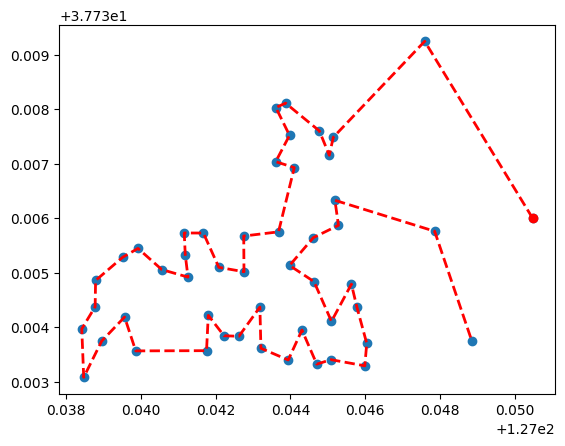

In [5]:
plt.figure()
plt.scatter(FullPoints[path_indices,0], FullPoints[path_indices,1])
plt.plot(FullPoints[path_indices,0], FullPoints[path_indices,1], 'r--', lw=2)
plt.plot(FullPoints[path_indices[0],0], FullPoints[path_indices[0],1], 'ro')
print("Benchmark tour length: %s" % benchtour)

In [6]:
FullPoints

array([[127.044102,  37.736928],
       [127.038785,  37.734374],
       [127.04394 ,  37.733397],
       [127.050467,  37.735998],
       [127.040565,  37.735056],
       [127.042759,  37.735017],
       [127.045628,  37.734789],
       [127.04387 ,  37.738111],
       [127.041806,  37.734216],
       [127.044612,  37.735643],
       [127.045144,  37.737485],
       [127.048847,  37.733737],
       [127.045187,  37.736328],
       [127.043681,  37.735749],
       [127.045079,  37.733403],
       [127.047584,  37.739246],
       [127.039571,  37.734185],
       [127.041164,  37.735728],
       [127.044307,  37.733946],
       [127.046037,  37.733701],
       [127.047849,  37.73576 ],
       [127.039929,  37.735445],
       [127.043184,  37.734368],
       [127.041264,  37.734918],
       [127.043976,  37.735132],
       [127.042226,  37.733842],
       [127.044629,  37.734835],
       [127.03848 ,  37.733079],
       [127.042752,  37.735672],
       [127.045095,  37.734106],
       [12

In [ ]:
path_indices